## 循环神经网络的从零实现
 从头开始基于循环神经网络实现<b>字符级语言模型</b>。 这样的模型将在H.G.Wells的《时光机器》数据集上训练。

In [1]:
%matplotlib inline
import math
import torch
from torch import nn
from torch.nn import functional as F
from d2l import torch as d2l

batch_size, num_steps = 32, 35
train_iter, vocab = d2l.load_data_time_machine(batch_size, num_steps)

## 字符需要以向量的形式输入网络中：使用独热编码表示索引
在train_iter中，每个词元都已经表示为一个数字索引了， 将这些索引直接输入神经网络可能会使学习变得困难（相当于就一个特征维度，太少了，导致模型参数也少，难以训练出有效的模型）。 所以我们通常使用独热编码来代替这个索引。

In [2]:
# 将子序列的每个词元转换成独热编码形式
F.one_hot(torch.tensor([0, 2]), 
          len(vocab)) # 总共多少个类别

tensor([[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0],
        [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0]])

## 修改输入形状

我们每次采样的小批量数据形状是二维张量： （批量大小，时间步数）。 one_hot函数将这样一个小批量数据转换成三维张量， 张量的最后一个维度等于词表大小（len(vocab)）。 我们经常转换输入的维度，以便获得形状为 （时间步数，批量大小，词表大小）的输出。（原因下面会体现）

时间步数：一个子序列中词元的个数

In [3]:
X = torch.arange(10).reshape((2, 5)) # 一批数据，批量大小=2，时间步数=5

F.one_hot(X.T, 28).shape

torch.Size([5, 2, 28])

## 初始化模型参数
 当训练语言模型时，输入和输出来自相同的词表。 因此，它们具有相同的维度(即词表的大小)。

In [10]:
def get_params(vocab_size, num_hiddens, device):
    """RNN模型需要训练的所有参数"""
    # 因为输入已经过独热编码，输出则是对每个类别的预测
    num_inputs = num_outputs = vocab_size
    # 初始化参数
    def normal(shape):
        return torch.randn(size=shape, device=device) * 0.01
    
    # 隐藏层参数
    W_xh = normal((num_inputs, num_hiddens)) # 对输入X的权重
    W_hh = normal((num_hiddens, num_hiddens)) # 隐藏层输出向量的权重
    b_h = torch.zeros(num_hiddens, device=device) # 隐藏层的偏置
    
    # 输出层参数
    W_hq = normal((num_hiddens, num_outputs)) # 对隐藏层的权重
    b_q = torch.zeros(num_outputs, device=device) # 输出层的偏置
    
    # 为模型参数设置需要梯度
    params = [W_xh, W_hh, b_h, W_hq, b_q]
    for param in params:
        param.requires_grad_(True)
    
    return params

## 循环神经网络
我们首先需要一个init_rnn_state函数初始化隐藏层的输出h_0。 这个函数的返回是一个张量，张量全用0填充（意为H1之和输入的字符有关了）， 形状为（批量大小，隐藏单元数）。 

In [11]:
def init_rnn_state(batch_size, num_hiddens, device):
    """初始化隐状态"""
    return (torch.zeros((batch_size, num_hiddens), 
                        device=device), )

下面的rnn函数定义了一个词元在网络中的前向传播过程。 循环神经网络模型通过inputs最外层的维度（词元个数）实现循环， 以便逐时间步更新小批量数据的隐状态H。(这就是修改输入形状的原因) 这里使用tanh作为激活函数

In [12]:
def rnn(inputs, state, params):
    """一个词元在RNN中的前向传播计算"""
    # 网络中的输入inputs的形状：(时间步数，批量大小，词表大小)
    W_xh, W_hh, b_h, W_hq, b_q = params
    H, = state # 获取初始的隐藏层输出
    outputs = []
    
    # X的形状：(批量大小，词表大小)
    # 不同子序列的词元没有时序关系
    # 进行前向传播
    for X in inputs:
        H = torch.tanh(torch.mm(X, W_xh) 
                       + torch.mm(H, W_hh) + b_h)
        # Y包含每个词元类别预测的概率，Y的形状（批量大小，词表大小）
        Y = torch.mm(H, W_hq) + b_q
        outputs.append(Y)
        
    return torch.cat(outputs, dim=0), (H,)

In [13]:
output = [torch.tensor([[1,2,3],
                        [10,11,12]]),
         torch.tensor([[4,5,6],
                       [13,14,15]])]
torch.cat(output, dim=0)

tensor([[ 1,  2,  3],
        [10, 11, 12],
        [ 4,  5,  6],
        [13, 14, 15]])

定义了所有需要的函数之后，接下来我们创建一个类来包装这些函数， 并存储从零开始实现的循环神经网络模型的参数。

In [14]:
class RNNModelScratch: 
    """从零开始实现的循环神经网络模型"""
    def __init__(self, vocab_size, num_hiddens, device,
                 get_params, init_state, forward_fn):
        self.vocab_size, self.num_hiddens = vocab_size, num_hiddens
        self.params = get_params(vocab_size, num_hiddens, device)
        self.init_state, self.forward_fn = init_state, forward_fn

    def __call__(self, X, state):
        # 将索引转换成独热编码再进行前向传播（利于模型训练）
        X = F.one_hot(X.T, self.vocab_size).type(torch.float32)
        return self.forward_fn(X, state, self.params)

    def begin_state(self, batch_size, device):
        """初始化隐藏层输出h_0"""
        return self.init_state(batch_size, self.num_hiddens, device)

让我们检查输出是否具有正确的形状。 例如，隐状态的维数是否保持不变。

In [15]:
num_hiddens = 512
net = RNNModelScratch(len(vocab), num_hiddens, d2l.try_gpu(), 
                      get_params, init_rnn_state, rnn)
# 初始化隐状态（隐藏层输出）
state = net.begin_state(X.shape[0], d2l.try_gpu())
Y, new_state = net(X.to(d2l.try_gpu()), state)
Y.shape, len(new_state), new_state[0].shape

(torch.Size([10, 28]), 1, torch.Size([2, 512]))

## 预测
定义一个预测函数：生成prefix之后的新字符，其中的prefix是一个用户提供的字符串。

在循环遍历prefix中的字符时， 我们不断地将隐状态传递到下一个时间步，但是不生成任何输出。 这被称为预热（warm-up）期，在此期间模型会自我更新（如更新隐状态）， 但不需要知道对每个词元的预测结果，因为我们知道真实的值，我们主要为了更新隐状态。

在预热期结束后，隐状态的值通常比刚开始的初始值更适合预测， 从而预测字符并输出它们。

In [19]:
def predict_ch8(prefix, num_preds, net, vocab, device): 
    """预测出prefix后的字符串"""
    state = net.begin_state(batch_size=1, device=device)
    # 输出的词元索引
    outputs = [vocab[prefix[0]]]
    
    get_input = lambda: torch.tensor([outputs[-1]], device=device).reshape((1, 1))
    
    for y in prefix[1:]:  # 预热期，更新隐状态
        # 对prefix每个词元进行预测
        _, state = net(get_input(), state)
        # 填入真实的词元索引，预热期不关心预测的，只是为了更新隐状态
        outputs.append(vocab[y])
    
    # 此时的state是最新状态
    for _ in range(num_preds):  # 预测num_preds个词元
        y, state = net(get_input(), state)
        # 填入预测的词元索引
        outputs.append(int(y.argmax(dim=1).reshape(1)))
    
    # 将词元索引全部转换成对应的词元
    return ''.join([vocab.idx_to_token[i] for i in outputs])

虽然还没训练，但是可以测试一下函数的输出结果，预测了'time traveller '之后的十个字符是啥

In [20]:
predict_ch8('time traveller ', 10, net, vocab, d2l.try_gpu())

'time traveller tkvoxp tkv'

## 梯度剪裁的实现
梯度裁剪可以防止梯度爆炸，但不能应对梯度消失。

In [21]:
def grad_clipping(net, theta): 
    """裁剪梯度"""
    if isinstance(net, nn.Module):
        params = [p for p in net.parameters() if p.requires_grad]
    else:
        params = net.params
    
    # 梯度向量的模
    norm = torch.sqrt(sum(torch.sum((p.grad ** 2)) for p in params))
    if norm > theta:
        for param in params:
            param.grad[:] *= theta / norm

## 训练
当使用顺序分区时，当前小批量数据最后一个样本的隐状态将用于初始化下一个小批量数据第一个样本的隐状态。

当使用随机抽样时，因为每个样本都是在一个随机位置抽样的， 因此需要为每个迭代周期重新初始化隐状态。

In [29]:
def train_epoch_ch8(net, train_iter, loss, updater, 
                    device, use_random_iter):
    """
    模型在一个epoch上的训练
    返回困惑度和运行速度
    
    """
    state, timer = None, d2l.Timer()
    metric = d2l.Accumulator(2)  # 训练损失之和,词元数量
    for X, Y in train_iter:
        if state is None or use_random_iter:
            # 在第一次迭代或使用的是随机抽样时需要初始化隐状态
            state = net.begin_state(batch_size=X.shape[0], device=device)
        else:
            if isinstance(net, nn.Module) and not isinstance(state, tuple):
                state.detach_()
            else:
                for s in state:
                    s.detach_()
        
        # 真实词元的索引
        y = Y.T.reshape(-1)
        X, y = X.to(device), y.to(device)
        
        # y_hat包含对每个词元预测的概率
        y_hat, state = net(X, state)
        l = loss(y_hat, y.long()).mean()
        if isinstance(updater, torch.optim.Optimizer):
            updater.zero_grad()
            l.backward()
            # 梯度剪裁
            # 很多情况下没有gradient_clip 会导致loss变成nan
            grad_clipping(net, 1)
            updater.step()
        else:
            l.backward()
            grad_clipping(net, 1)
            # 因为已经调用了mean函数(d2l实现的sgd我不满意)
            updater(batch_size=1)
        
        metric.add(l * y.numel(), y.numel())
    return math.exp(metric[0] / metric[1]), metric[1] / timer.stop()

In [30]:
def train_ch8(net, train_iter, vocab, lr, num_epochs, device,
              use_random_iter=False):
    loss = nn.CrossEntropyLoss(reduction='none')
    animator = d2l.Animator(xlabel='epoch', ylabel='perplexity',
                            legend=['train'], xlim=[10, num_epochs])
    # 初始化
    if isinstance(net, nn.Module):
        updater = torch.optim.SGD(net.parameters(), lr)
    else:
        updater = lambda batch_size: d2l.sgd(net.params, lr, batch_size)
    
    predict = lambda prefix: predict_ch8(prefix, 50, net, vocab, device)
    
    # 训练和预测
    for epoch in range(num_epochs):
        # -----------train----------
        ppl, speed = train_epoch_ch8(
                net, train_iter, loss, updater, device, use_random_iter
            )
        # -----------valid----------
        if (epoch + 1) % 10 == 0:
            print(predict('time traveller '))
            animator.add(epoch + 1, [ppl])
    
    print(f'困惑度 {ppl:.1f}, {speed:.1f} 词元/秒 {str(device)}')
    print(predict('time traveller'))
    print(predict('traveller'))

困惑度 1.0, 116667.2 词元/秒 cuda:0
time traveller with a slight accession ofcheerfulness really thi
traveller with a slight accession ofcheerfulness really thi


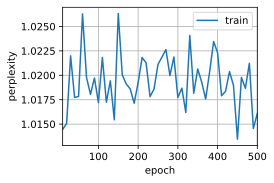

In [31]:
num_epochs, lr = 500, 1
train_ch8(net, train_iter, vocab, lr, num_epochs, d2l.try_gpu())

最后，让我们检查一下使用随机抽样方法的结果。

困惑度 1.3, 112865.9 词元/秒 cuda:0
time traveller held in his hand was a glitteringmetallic framewo
traveller held in his hand was a glitteringmetallic framewo


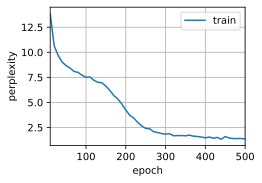

In [25]:
net = RNNModelScratch(len(vocab), num_hiddens, 
                      d2l.try_gpu(), get_params,
                      init_rnn_state, rnn)
train_ch8(net, train_iter, vocab, lr, num_epochs, d2l.try_gpu(),
          use_random_iter=True)